In [62]:
%pylab inline

import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


C:\Users\Rollan\Miniconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning:

pylab import has clobbered these variables: ['product']
`%matplotlib` prevents importing * from pylab and numpy



In [63]:
data = pd.read_csv('WAG_C_M.csv', sep=';', index_col=['month'], parse_dates=['month'], dayfirst=True)

In [65]:
data.head()

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


### Визуальный анализ ряда


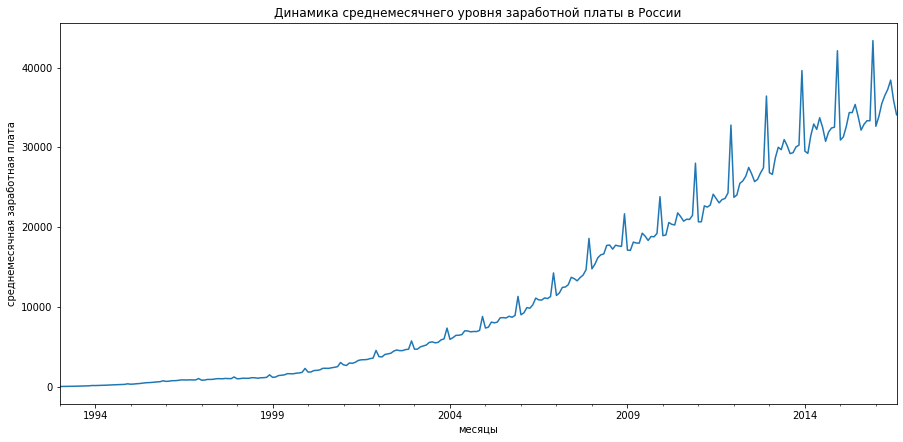

In [69]:
plt.figure(figsize(15,7))
data.WAG_C_M.plot()
plt.ylabel('среднемесячная заработная плата')
plt.xlabel('месяцы')
plt.title('Динамика среднемесячнего уровня заработной платы в России')
pylab.show()

In [70]:
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M)[1])

Критерий Дики-Фуллера: p=0.991850


Согласно тесту Дики-Фуллера временной ряд является нестационарным (существует ярковыраженный тренд и сезонность данных). Также, как видно из вышеприведенного графика, в данных наблюдается дисперсия тренда (меняется амплитуда колебаний во времени). Для начала решим вопрос со стабилизацией дисперсии. В нашем случае будет применена функция преобразования Бокса-Кокса

### Стабилизация дисперсии

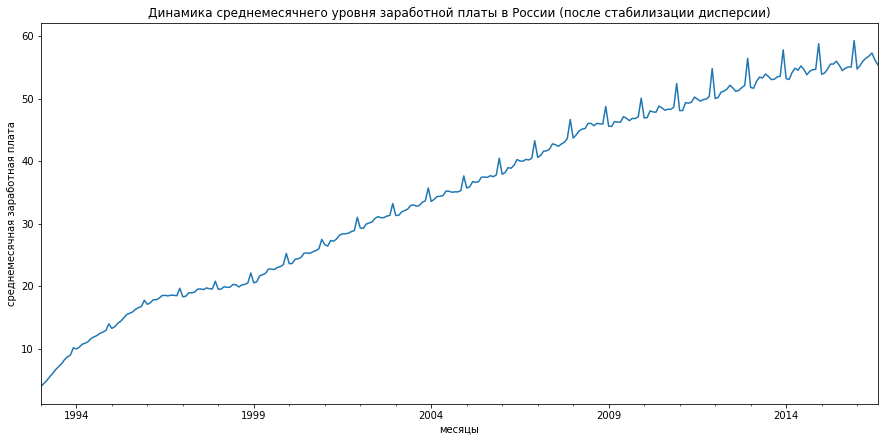

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


In [72]:
data['WAG_BOX'], lmbda = stats.boxcox(data.WAG_C_M)
data.WAG_BOX.plot()
plt.ylabel('среднемесячная заработная плата')
plt.xlabel('месяцы')
plt.title('Динамика среднемесячнего уровня заработной платы в России (после стабилизации дисперсии)')
pylab.show()

print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.WAG_BOX)[1])

### Выбор порядка дифференцирования

После сравнения двух графиков можно увидеть заметное снижение амплитуды колебаний в данных. Но при этом сохраняется высокий уровень нестационарности данных (тест Дики-Фуллера). Тем самым, необходимо применить дополнительное преобразование временного ряда.

Для опеределения порядка дифференцирования полезно "разбить" имеющиеся данные на следующие составляющие: тренд, сезонность и остатки.

Критерий Дики-Фуллера: p=0.696899


<Figure size 720x432 with 0 Axes>

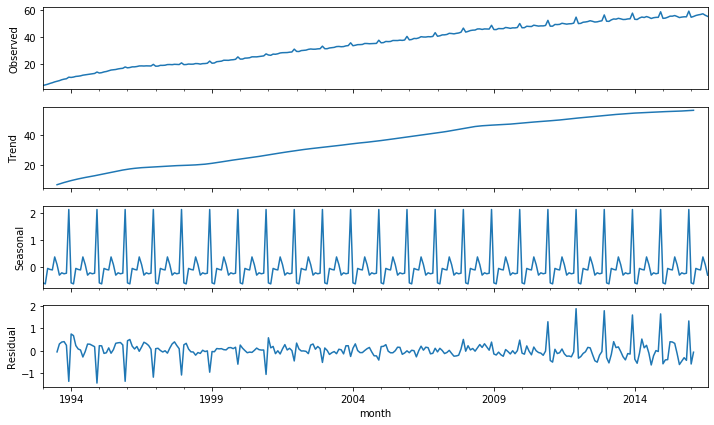

In [90]:
plt.figure(figsize(10,6))
sm.tsa.seasonal_decompose(data.WAG_BOX).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.WAG_BOX)[1])

График подтверждает мнение о наличии тренда и сезонности данных. Согласно рекомендациям курса сперва попытаемся снизить сезонность данных. Из рисунка видна годовая сезонность и поэтому необходимо продифференцировать ряд на лаг равный 12. После преобразований построим график заново.

Критерий Дики-Фуллера: p=0.014697


<Figure size 720x432 with 0 Axes>

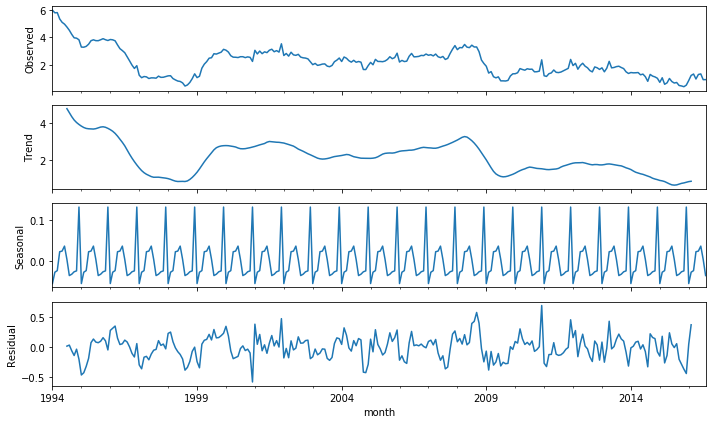

In [91]:
data['WAG_BOX_diff12'] = data.WAG_BOX - data.WAG_BOX.shift(12)
plt.figure(figsize(10,6))
sm.tsa.seasonal_decompose(data.WAG_BOX_diff12[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.WAG_BOX_diff12[12:])[1])

Тест Дики-Фуллера показал, что преобразованный ряд стал стационарным. Но, при этом, можно заметить о сохранении определенных трендов в данных (случайное блуждание). Поэтому продифференцируем наш ряд еще раз к предыдущему значения ряда.

Критерий Дики-Фуллера: p=0.000000


<Figure size 720x432 with 0 Axes>

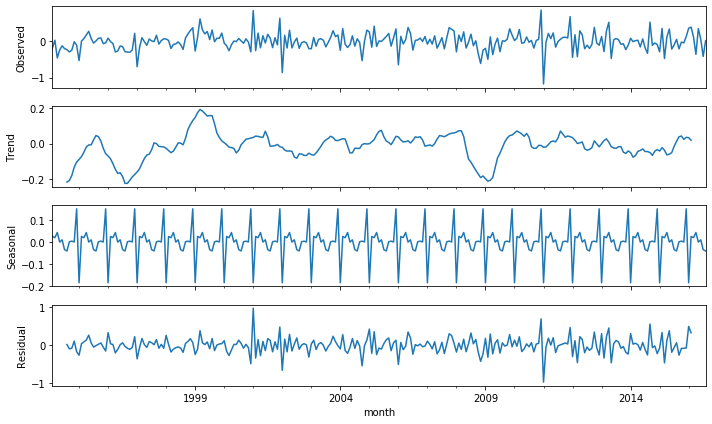

In [92]:
data['WAG_BOX_diff121'] = data.WAG_BOX_diff12 - data.WAG_BOX_diff12.shift(1)
plt.figure(figsize(10,6))
sm.tsa.seasonal_decompose(data.WAG_BOX_diff121[13:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.WAG_BOX_diff121[13:])[1])

Ряд данных заметно улучшился. Сохраняются определенные отклонения в тренде, но это больше связана с большими резонансами в указанные временные периоды: Азиатский кризис в 90-х и Финансовый кризис в 00-х. Теперь необходимо подобрать параметры для построения модели прогнозирования.

### Выбор начальных приближений для p, q, P, Q

Для экспертного подбора начальных приближений для параметров необходимо проанализировать автокорреляционную и частично автокорреляционную функцию.

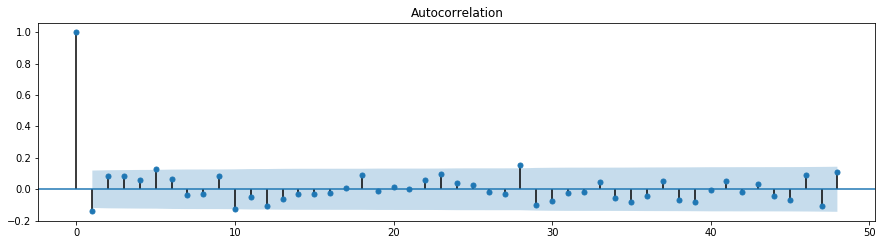

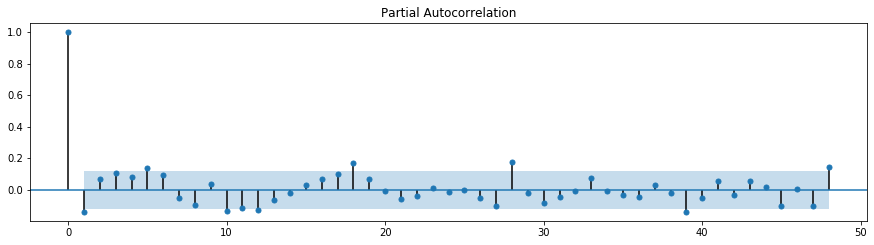

In [93]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.WAG_BOX_diff121[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data.WAG_BOX_diff121[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Начальные приближения: Q=0, q=1, P=1, p=5

In [94]:
ps = range(0, 6)
d=1
qs = range(0, 2)
Ps = range(0, 2)
D=1
Qs = range(0, 1)

In [95]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

24

In [96]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.WAG_BOX, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (2, 1, 0, 0)
wrong parameters: (2, 1, 1, 0)
Wall time: 10.6 s


In [97]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters       aic
21  (5, 1, 1, 0) -5.260133
13  (3, 1, 1, 0) -4.995859
19  (5, 0, 1, 0) -4.545935
17  (4, 1, 1, 0) -3.975973
18  (5, 0, 0, 0) -2.104961


С помощью информационного критерия Акаике были подобраны параметры будущей модели.

In [98]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                            WAG_BOX   No. Observations:                  284
Model:             SARIMAX(5, 1, 1)x(1, 1, 0, 12)   Log Likelihood                  10.630
Date:                            Wed, 27 May 2020   AIC                             -5.260
Time:                                    13:19:12   BIC                             23.557
Sample:                                01-01-1993   HQIC                             6.310
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2017      0.436      0.462      0.644      -0.653       1.057
ar.L2          0.0993      0.105   

### Анализ остатков построенной модели, при необходимости — её модификация: если остатки получаются смещёнными, прогноз нужно скорректировать на константу; если остатки нестационарны или автокоррелированы, можно попробовать расширить область, в которой подбираются значения p, q, P, Q.

Критерий Стьюдента: p=0.296201
Критерий Дики-Фуллера: p=0.000000


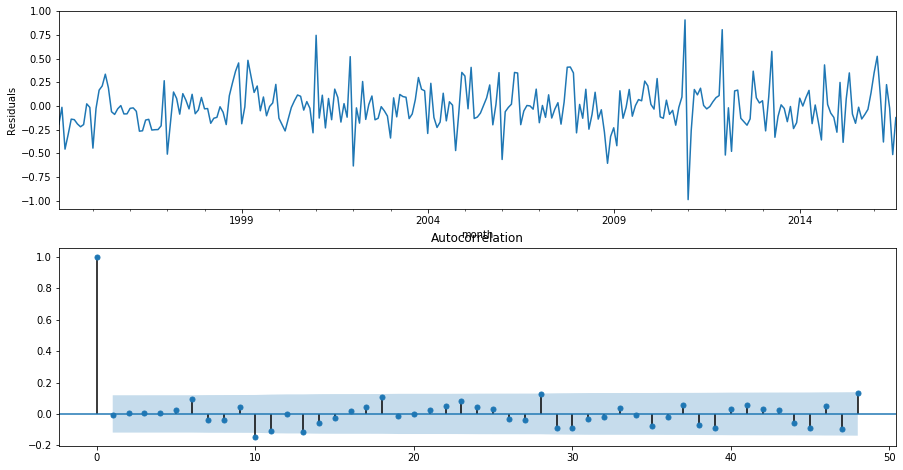

In [99]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).
Посмотрим, насколько хорошо модель описывает данные:

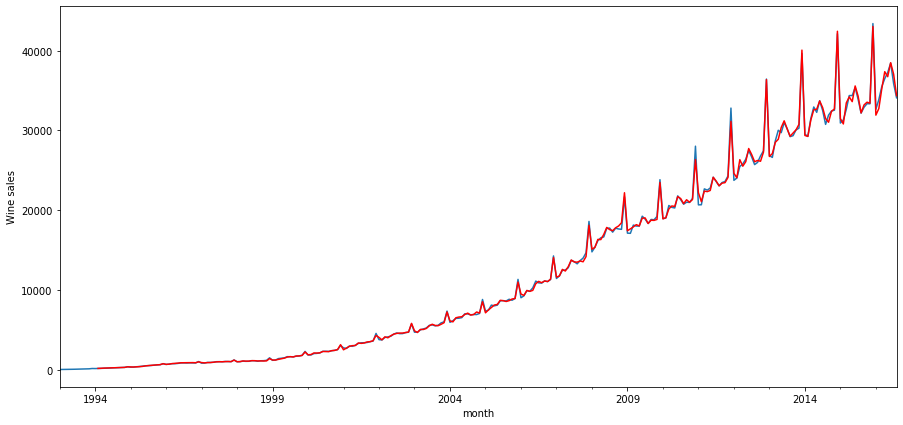

In [100]:
data['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
data.WAG_C_M.plot()
data.model[13:].plot(color='r')
plt.ylabel('Wine sales')
pylab.show()

### Прогнозирование с помощью финальной модели

In [102]:
data.head()

,WAG_C_M,WAG_BOX,WAG_BOX_diff12,WAG_BOX_diff121,model
month,,,,,
1993-01-01,15.3,3.990393,NaN,NaN,1.0
1993-02-01,19.1,4.458758,NaN,NaN,15.3
1993-03-01,23.6,4.931635,NaN,NaN,19.1
1993-04-01,30.6,5.549430,NaN,NaN,23.6
1993-05-01,37.5,6.063406,NaN,NaN,30.6


C:\Users\Rollan\Miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:320: FutureWarning:

Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.



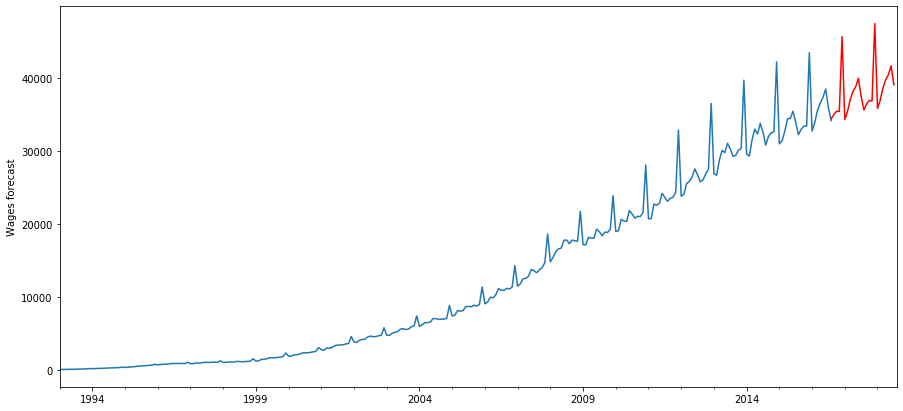

In [105]:
data2 = data[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index=date_list, columns= data2.columns)
data2 = pd.concat([data2, future])
data2['forecast'] = invboxcox(best_model.predict(start=283, end=306), lmbda)

plt.figure(figsize(15,7))
data2.WAG_C_M.plot()
data2.forecast.plot(color='r')
plt.ylabel('Wages forecast')
pylab.show()

По итогам прогнозирования можно сделать вывод, что тренд в последующие два года не будет сильно отличаться от имеющихся значений. Подобное явление скорее всего можно объяснить отсутствием циклов в исторических данных и предпложение, что в данных учтены лишь номинальные заработные платы россиян, а не реальные, которым свойственно чаще менять направление тренда.